# Загрузка данных и библиотек

In [1]:
#pip install sklearn

In [2]:
#pip install transformers

In [3]:
#pip install tensorflow

In [4]:
#conda activate tf

In [5]:
#pip install tensorflow

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import tempfile

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SVMSMOTE

from tensorflow import keras, feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
# Последовательная модель НС
from tensorflow.keras.models import Sequential  
# Основные слои
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 
# Утилиты для to_categorical()
from tensorflow.keras import utils   
# Алгоритмы оптимизации для обучения модели
from tensorflow.keras.optimizers import Adam, Adadelta   
# Связь с google-диском
#from google.colab import files   
# Предварительная обработка данных
from sklearn.preprocessing import LabelEncoder   

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']   

file_path = 'chd_addmit_1500.xlsx'
# удаляем даты
dataframe = pd.read_excel(file_path).drop(['birth','admittion','discharge', 'Дата опер.'], axis=1)

dataframe = dataframe[['Диагноз','Принимаемые препараты (из Анамн.)', 'target']]


In [7]:
# англофикация названий признаков. Необходимо для сохранения модели
count = 0
data = dataframe.copy()
for col in data.drop('target', axis=1).columns:
    data = data.rename(columns={col: f"col_{count}"})
    count += 1
    
dataframe = data


# Входной пайплайн df_to_dataset. Подготовка датасета. Предобработка. Сплит на выборки

Первый шаг заключается в преобразовании датафреймов Pandas в наборы данных TensorFlow:

In [8]:
import transformers as ppb
import re

In [9]:
%%time
# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=256):
  df = dataframe.copy() 
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  if 'target' in dataframe.columns:
    ds = tf.data.Dataset.from_tensor_slices((dict(df), df.pop('target')))
  else:
    ds = tf.data.Dataset.from_tensor_slices(dict(df))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Делаем заглушки
for col in dataframe.columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    dataframe[col] = dataframe[col].fillna(dataframe[col].median())

for col in dataframe.columns.tolist():
  if dataframe[col].dtypes == 'object':
    dataframe[col] = dataframe[col].fillna('Нет данных')
    

CPU times: total: 0 ns
Wall time: 2 ms


In [10]:
# Разделяем на выборки
X_train, X_test, y_train, y_test = train_test_split(dataframe, dataframe['target'], 
                                                      test_size=0.3, 
                                                      random_state=5,
                                                      stratify=dataframe['target'])

# RandomOverSampler. Балансируем классы!
X_train, y_train = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)

# SVMSMOTE. Балансируем классы!
#svmsmote = SVMSMOTE(random_state = 5)
#X_train, y_train = svmsmote.fit_resample(X_train, y_train)
#X_train, y_train = shuffle(X_train, y_train)
#X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
#could not convert string to float: 'f'

# Преобразуем датафрейм Pandas в наборы данных TensorFlow
batch_size = 256
train_ds = df_to_dataset(X_train, batch_size=batch_size)
test_ds = df_to_dataset(X_test.drop('target',axis=1), shuffle=False, batch_size=batch_size)


Здесь стоит обратить внимание на то, что наборы данных TensorFlow и результаты дальнейших преобразований данных не хранятся в памяти так же, как хранятся датафреймы Pandas. Они, по сути, представляют собой конвейер. Через него, пакет за пакетом, походят данные, что позволяет модели эффективно обучаться на наборах данных, которые слишком велики для размещения их в памяти. Именно поэтому мы преобразуем в наборы данных словари датафреймов, а не реальные данные. Обратите внимание на то, что мы, кроме прочего, задаём сейчас, а не во время обучения модели, размер пакета данных, поступая не так, как обычно поступают при использовании API Keras.

## Нормализация входных/выходных данных

In [11]:
%%time
# предобработка слоя с числовыми призанками
def get_normalization_layer(name, dataset):
  # Создаем слой нормализации для объекта.
  normalizer = layers.Normalization(axis=None)
  # Подготовка набора данных, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Обучить статистику данных.
  normalizer.adapt(feature_ds)
  return normalizer

# предобработка слоя с категориальными призанками
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Создается слой, который превращает строки в целые индексы.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # В противном случае создается слой, который превращает целые значения в целые индексы.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)
  # Подготовка `tf.data.Dataset`, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Изучить набор возможных значений и присвоить им фиксированный целочисленный индекс.
  index.adapt(feature_ds)
  # Кодировать целочисленные индексы.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  # Применить многократное горячее кодирование к индексам. Лямбда-функция захватывает слои,
  # чтобы вы могли использовать их или позже включить в функциональную модель Keras.
  return lambda feature: encoder(index(feature))

all_inputs = []
encoded_features = []

# Numerical features.
for header in dataframe.drop('target',axis=1).columns.tolist():
  if dataframe[header].dtypes in ['float64', 'int64']:
    # inputs
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    # output
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    # append
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

# Сategorical features.
categorical_cols = dataframe.loc[:,dataframe.dtypes == 'object'].columns.tolist()
for header in categorical_cols:
    # inputs
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # output
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=25)
    encoded_categorical_col = encoding_layer(categorical_col)
    # append
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


Cause: could not parse the source code of <function get_category_encoding_layer.<locals>.<lambda> at 0x000002420D837E20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function get_category_encoding_layer.<locals>.<lambda> at 0x000002420D837E20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function get_category_encoding_layer.<locals>.<lambda> at 0x000002420D837E20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function get_category_encoding_layer.<locals>.<lambda> at 0x000002420D837E20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.

In [12]:
# inputs
display(all_inputs)


[<KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_0')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'col_1')>]

In [13]:
# output
display(encoded_features)


[<KerasTensor: shape=(None, 25) dtype=float32 (created by layer 'category_encoding')>,
 <KerasTensor: shape=(None, 25) dtype=float32 (created by layer 'category_encoding_1')>]

```python
%%time



# модуль обучения
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

data = pd.DataFrame()
Activation = []
dropout = []

for a in ['relu', 'linear']:
    for d in [0.1, 0.2]:
            output_bias = None
            if output_bias is not None:
                output_bias = tf.keras.initializers.Constant(output_bias)

            all_features = tf.keras.layers.concatenate(encoded_features)        # входной. слой признаков

            x = tf.keras.layers.Dense(512, activation=a)(all_features)  
            x = tf.keras.layers.Dropout(d)(x)                                 
            x = tf.keras.layers.BatchNormalization()(x) 
            x = tf.keras.layers.Dense(256, activation=a)(x)  
            x = tf.keras.layers.Dropout(d)(x)                                 
            x = tf.keras.layers.BatchNormalization()(x) 
            x = tf.keras.layers.Dense(128, activation=a)(x)  
            x = tf.keras.layers.Dropout(d)(x)                                 
            x = tf.keras.layers.BatchNormalization()(x)           
            x = tf.keras.layers.Dense(64, activation=a)(x)
            x = tf.keras.layers.Dropout(d)(x)                                 
            x = tf.keras.layers.BatchNormalization()(x) 
            x = tf.keras.layers.Dense(32, activation=a)(x)                      

            output = tf.keras.layers.Dense(1, activation='sigmoid')(x)          # выходной слой

            model = tf.keras.Model(all_inputs, output)

            model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                          loss=keras.losses.BinaryCrossentropy(),
                          metrics=METRICS)

            history = model.fit(train_ds, batch_size=8, epochs=2500, verbose=0)
            data = data.append(pd.DataFrame(history.history)[-1:])
            Activation.append(a)
            dropout.append(d)

data['Activation'] = Activation
data['dropout'] = dropout
(data.sort_values('prc', ascending=False).sort_values('loss', ascending=True)
                  .sort_values(['tp', 'tn'], ascending=False).sort_values(['fp', 'fn'], ascending=True)
                  .sort_values(['precision', 'recall'], ascending=False))[:3]
```

# Итоговая модель

In [14]:
 %%time

a, Batch_size, d = 'linear', 8, 0.1
    
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  all_features = tf.keras.layers.concatenate(encoded_features)        # входной. слой признаков
 
  x = tf.keras.layers.Dense(512, activation=a)(all_features)  
  x = tf.keras.layers.Dropout(d)(x)                                 
  x = tf.keras.layers.BatchNormalization()(x) 
  x = tf.keras.layers.Dense(256, activation=a)(x)  
  x = tf.keras.layers.Dropout(d)(x)                                 
  x = tf.keras.layers.BatchNormalization()(x) 
  x = tf.keras.layers.Dense(128, activation=a)(x)  
  x = tf.keras.layers.Dropout(d)(x)                                 
  x = tf.keras.layers.BatchNormalization()(x)           
  x = tf.keras.layers.Dense(64, activation=a)(x)
  x = tf.keras.layers.Dropout(d)(x)                                 
  x = tf.keras.layers.BatchNormalization()(x) 
  x = tf.keras.layers.Dense(32, activation=a)(x)                        

  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)          # выходной слой

  model = tf.keras.Model(all_inputs, output)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.001), #
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model = make_model()

model.fit(train_ds,
          batch_size=Batch_size, 
          epochs=2500,
          verbose=0)

print('Готово!')


Готово!
CPU times: total: 9min 49s
Wall time: 2min 37s


# Исправляем дисбаланс

In [15]:
%%time
w = 'base_weights'
# базовые весы
model.save_weights(f'{w}/{w}', save_format='tf')
b_results = round(model.evaluate(train_ds, verbose=0)[0],3)
print(f"{w} Loss: {b_results}")

w = 'initial_weights'
# Изучим дисбаланс ярлыков классов
neg, pos = np.bincount(y_train)
total = neg + pos
# Необязательно: правильное начальное смещение initial_weights
initial_bias = np.log([pos/neg])
iw_model = make_model(output_bias=initial_bias)
iw_model.layers[-1].bias.assign([0.0])
iw_model.fit(
    train_ds,
    batch_size=Batch_size,
    epochs=2500,
    verbose=0)
# initial_weights
iw_model.save_weights(f'{w}/{w}', save_format='tf')
iw_results = round(iw_model.evaluate(train_ds, verbose=0)[0],3)
print(f"{w} Loss: {iw_results}")

## Исправление дисбаланса
# Контрольные точки начальных весов
# Чтобы сделать различные тренировочные прогоны более сопоставимыми, 
# сохраним веса исходной модели в файле контрольных точек и загрузим их в каждую модель перед тренировкой.

w = 'class_weight'
# Рассчитать веса классов
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
# модель
weighted_model = make_model()
if iw_results < b_results:
    weighted_model.load_weights('initial_weights/initial_weights') # если initial лучше base weights
weighted_model.fit(
    train_ds,
    batch_size=Batch_size,
    epochs=2500,
    # The class weights go here
    class_weight=class_weight, 
    verbose=0)
w_results = round(weighted_model.evaluate(train_ds, verbose=0)[0],3)
weighted_model.save_weights(f'{w}/{w}', save_format='tf')
print('\nWeight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print(f"{w} Loss: {w_results}")

if w_results < iw_results and w_results < b_results:
    model.load_weights('class_weight/class_weight')
elif iw_results < w_results and iw_results < b_results:
    model.load_weights('initial_weights/initial_weights')
elif b_results < iw_results and b_results < w_results:
    model.load_weights('base_weights/base_weights')

# Примечание.Использование `class_weights` изменяет диапазон потерь. 
# Это может повлиять на стабильность обучения в зависимости от оптимизатора. 
# Оптимизаторы, размер шага которых зависит от величины градиента, например `tf.keras.optimizers.SGD` , 
# могут дать сбой. Используемый здесь оптимизатор, `tf.keras.optimizers.Adam` , 
# не зависит от изменения масштаба. Также обратите внимание, 
# что из-за взвешивания общие потери между двумя моделями несопоставимы.


base_weights Loss: 0.412
initial_weights Loss: 0.412

Weight for class 0: 1.00
Weight for class 1: 1.00
class_weight Loss: 0.412
CPU times: total: 19min 52s
Wall time: 5min 26s


# Тест

In [16]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 col_0 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 col_1 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['col_0[0][0]']                  
                                                                                                  
 string_lookup_1 (StringLookup)  (None, 1)           0           ['col_1[0][0]']                  
                                                                                              

2/2 [==============================] - 0s 2ms/step


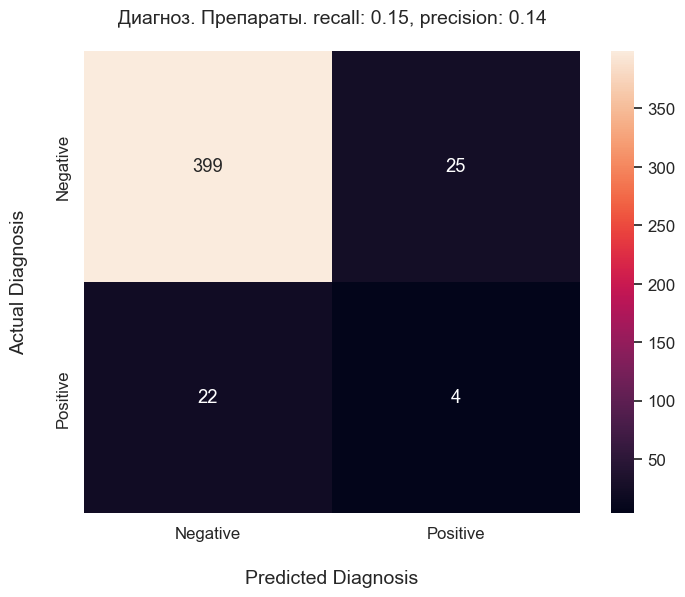

In [17]:
# предобработка результата
predict_proba_one = np.array(pd.Series([x[0] for x in model.predict(test_ds)]), 'float32')
y_pred = np.array(pd.Series([1 if x[0]>0.5 else 0 for x in model.predict(test_ds)]), 'int64')
y_test.reset_index(drop=True)

# проверим модель на эффективность. Выводим матрицу ошибок
recall = ("recall: %.2f" % recall_score(y_test, y_pred))
precision = ("precision: %.2f" % precision_score(y_test, y_pred))

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title(f"Диагноз. Препараты. {recall}, {precision}", fontsize=14, pad=20)
plt.show()


In [18]:
# сохраниение. создать папку с моделью
#model.save('VPS_by_kids_NLP_model', save_format='tf')

# загрузить модель из папки
# from keras.models import load_model
# model = load_model('VPS_by_kids_NLP_model')

INFO:tensorflow:Assets written to: VPS_by_kids_NLP_model\assets


INFO:tensorflow:Assets written to: VPS_by_kids_NLP_model\assets
